# Maximum Likelihood as a linear regression problem


**Goal:** In this notebook you will learn how to calculate the maximum likelihood loss which is also the negative log likelihood, for an regression problem. You will define the negative log likelihood (NLL) loss function in Keras and use it to optimize the weights of a regression network. You will see that minimizing the NLL us the same as minimizing the mean squared error (MSE). You will learn that the optimal weights do not depend on $\sigma^2$  when you assume that the variance $\sigma^2$ is constant. In an second example you will try to minimize the NLL for 4 obervation pairs by changing $\mu$ and $\sigma^2$ with sliders and by using Tensorflow.

**Usage:** We recommend to read chapter 4.3 before working through this notebook. The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. In addition you will find two exercises where you can do some experiments by yourself.

**Dataset:** For the first experiment, you work with the systolic blood pressure and age data of 33 American women. For the second experiment you work with four observed blood pressure values.

**Content:**

* First experiment on fitting a linear regression model
 * define the density function of a Normal distribution with constant variance.  
 * define a custom loss for the NLL
 * fit a linear regression model for the blood pressure data with the NLL loss 
 * see that the weights of the NN do not depend on $\sigma^2$ 


* Second experiment on fitting a Normal distribution
 * Plot a Normal distribution along with the likelihood of the observed values as shown in figure 4.17
 * Manually adapt the parameter values of the Normal distribution to achieve a maximal joint likelihood or minimal NLL 
 * use Tensorflow to optimize  $\mu$ and $\sigma^2$ automatically by minimizing the NLL


[open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_03.ipynb)

#### Imports
In the next two cells, we load all the required libraries. 

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.1.0-rc1  running in colab?:  True


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras import optimizers

tf.__version__

'2.1.0-rc1'

## Define a custom functions for the Normal densitiy and the NLL

Now let's define a function that calculates the density $f(y,\mu,\sigma)$ of a normal distribution at $y$, given the parameters $\mu$ and $\sigma$ using the formula:

$$
  f(y, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(y - \mu)^2}{2 \sigma^2}}
$$

we will keep $\sigma$ to the fixed value 20.


In [0]:
def f(y, mu, sigma=20):
  return (1/(sigma * tf.math.sqrt(2 * np.pi)) * tf.math.exp( - (y - mu)**2 / (2 * sigma**2)))

In the next cell we want to use the functon to calculate the density of a normal distribution at the systolic blood pressure $y=131$, for a given $\mu=111$ and $\sigma=20$.
Compare the result with the Figure 4.13 in the book.

In [5]:
f(131, 111)

<tf.Tensor: shape=(), dtype=float32, numpy=0.012098536>

Text(0, 0.5, 'probability density')

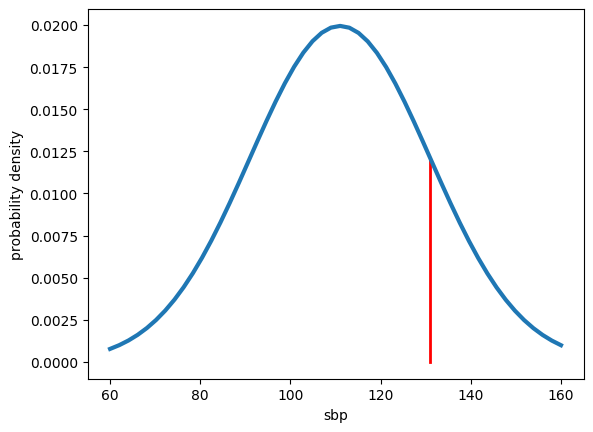

In [6]:
sbp = np.linspace(60,160,50, dtype='float32')
plt.plot([131, 131], [0, f(131,111)], 'k-', lw=2,color='red')
plt.plot(sbp, f(sbp, 111),linewidth=3)
plt.xlabel('sbp')
plt.ylabel('probability density')

## First experiment on fitting a linear regression model

Here we define the systolic blood pressure and the age of the 33 American women of our dataset

In [0]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9, 
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114, 
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217] 
x = np.asarray(x, np.float32) 
y = np.asarray(y, np.float32)

Let's fit a simple linear regression to the systolic blood pressure of the 33 women. You can assume a constant variance and a mean that depends linearly on the age. Therefor you setup a NN without any hidden layer and only one output node for the mean of the CPD.  The NLL for this case is the MSE which is a standard loss function in Keras (recall chapter 3). You still use here the custom loss function for the NLL to check that it yields the same result as you got with the Keras MSE loss.


To create a custom loss function, you have to follow the interface 
 `loss(y_true, y_pred)`.
 
We define the loss as follows:
$
    l = -\sum_{i=1}^n \log (f(y_i, a \cdot x+b)) =  -\sum_{i=1}^n \log(f(y_i, ypred_i)) 
$

In [0]:
# custom loss function
def my_loss(y_true,y_pred): #A
  loss = -tf.reduce_sum(tf.math.log(f(y_true,y_pred)))
  return loss

# setup NN w/o hidden layer and with output node
model = Sequential() 
model.add(Dense(1, activation='linear', 
                batch_input_shape=(None, 1)))
model.compile(loss=my_loss,optimizer="adam") # use custom loss


In [9]:
# fit the model and give out the two weights of the NN (slobe and intercept)
for i in range(0,120000):
    model.fit(x=x,y=y,batch_size=33,
                    epochs=1,
                    verbose = 0)
    a,b=model.get_weights()
    if i % 5000==0:
        mse=np.mean(np.square(model.predict(x).reshape(len(x),)-y))
        print("Epoch:",i,"slope=",a[0][0],"intercept=",b[0],"MSE=",mse)

#Should reach (you might need to do more iteration)
#1.   optimal value for slope: 1.1050216
#2.   optimal value for intercept: 87.67143
#3.   minimal MSE: 349.200787168560

Epoch: 0 slope= 0.88680553 intercept= 0.0010000294 MSE= 9913.936
Epoch: 5000 slope= 2.740187 intercept= 2.9659872 MSE= 1145.2219
Epoch: 10000 slope= 2.6528952 intercept= 7.3895946 MSE= 1064.2396
Epoch: 15000 slope= 2.5575027 intercept= 12.32315 MSE= 979.05725
Epoch: 20000 slope= 2.462377 intercept= 17.256731 MSE= 899.2754
Epoch: 25000 slope= 2.3673306 intercept= 22.187227 MSE= 824.93896
Epoch: 30000 slope= 2.2724705 intercept= 27.108685 MSE= 756.118
Epoch: 35000 slope= 2.1776783 intercept= 32.025845 MSE= 692.7242
Epoch: 40000 slope= 2.0831127 intercept= 36.932262 MSE= 634.81616
Epoch: 45000 slope= 1.988545 intercept= 41.83415 MSE= 582.2957
Epoch: 50000 slope= 1.8944049 intercept= 46.72191 MSE= 535.235
Epoch: 55000 slope= 1.8003876 intercept= 51.598526 MSE= 493.56424
Epoch: 60000 slope= 1.706715 intercept= 56.457146 MSE= 457.29483
Epoch: 65000 slope= 1.6135086 intercept= 61.293034 MSE= 426.3963
Epoch: 70000 slope= 1.5208349 intercept= 66.10063 MSE= 400.8219
Epoch: 75000 slope= 1.4291476

When we minimize the negativ log likelihood, the optimal values for the slope and intercept are the same as in chapter 3, where we minized the MSE!


### Exercise 1 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the value of sigma in the calculation of the likelihood (function f) and rerun the cells. Does the result depend on it?*

Scroll down to see the solution.
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

**Solution**

No, the result does not on the value of the variance which is a assumed to be constant.

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  

## Second experiment on fitting a Normal distribution model

In the next cells you will assume that you observed the systolic blood pressure of 4 women of the same age:   sbp=[131,105,114,117].
Let's plot a normal distribution along with the likelihood of the observed values,
Your task is to manually adapt the parameters $\mu$ and $\sigma$ of the Normal distribution (with the interactive silders) that yield a maximal joint likelihood which you get with the same parameter values that yield a minimal NLL.



In [0]:
#!pip install ipywidgets

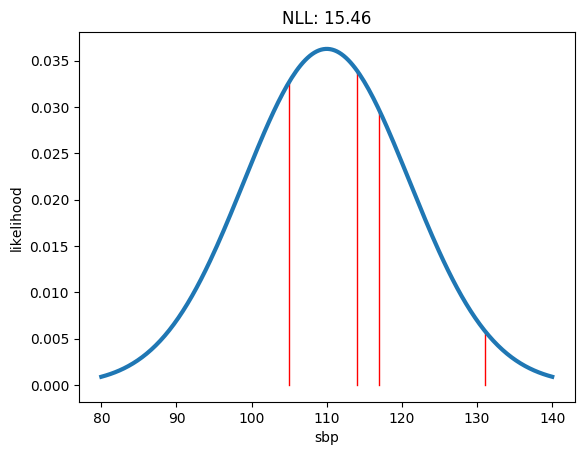

In [0]:
from ipywidgets import interactive
plt.figure(figsize=(5,5))
ys=np.array([131,105,114,117], dtype='float32')
sbp = np.linspace(80,140,200, dtype='float32')

def make_interactive(mu, sigma):
    likelihoods = f(ys, mu,sigma)
    for i in range(4):
        plt.plot([ys[i], ys[i]], [0, likelihoods[i]], 'k-', lw=1,color='red') 
    plt.plot(sbp, f(sbp, mu,sigma),linewidth=3)
    plt.xlabel('sbp')
    plt.ylabel('likelihood')
    plt.title('NLL: {:.2f}'.format(-np.sum(np.log(likelihoods))))

interactive(make_interactive,mu=(90, 130, 1), sigma=(2,20,1))

### Exercise 2
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

Exercise 2: Use TF to fit a Normal distribution that minimizes the NLL for the systolic blood pressure of the 4 observed sbp values . Compare the results with your manually determined parameters $\mu$ and $\sigma$.

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

**Note TODO After release of TF 2.0**

Needs some inverstigation. How to do this the TF2.0 way after the release.

In [0]:
mu     = tf.Variable(124.0)
sigma =  tf.Variable(10.0)
variables = [mu,sigma]
#eta = 0.0004
#likelihoods = f(ys, mu,sigma)
#loss = -tf.math.reduce_sum(tf.math.log(likelihoods)) 
optimizer = tf.optimizers.Adam()


In [14]:
# Gradient Decent with TF in eager modus:
for i in range(10000):
  with tf.GradientTape() as tape: #Record the gradients from now on
    likelihoods = f(ys, mu,sigma)
    loss = -tf.math.reduce_sum(tf.math.log(likelihoods))
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    #grad_mu, grad_sigma  = tape.gradient(loss, [mu,sigma])
    #mu = tf.Variable(mu - eta * grad_mu)
    #sigma = tf.Variable(sigma - eta * grad_sigma)

    if (i % 250 == 0):
      print("Epoch:",i, "mu=",mu.numpy(),"sigma=",sigma.numpy(), "NNL=", loss.numpy())

Epoch: 0 mu= 123.999 sigma= 10.001 NNL= 15.681095
Epoch: 250 mu= 123.75322 sigma= 10.235319 NNL= 15.580299
Epoch: 500 mu= 123.51592 sigma= 10.434735 NNL= 15.498944
Epoch: 750 mu= 123.28526 sigma= 10.599915 NNL= 15.4315815
Epoch: 1000 mu= 123.05974 sigma= 10.730648 NNL= 15.374268
Epoch: 1250 mu= 122.837746 sigma= 10.826036 NNL= 15.323981
Epoch: 1500 mu= 122.61827 sigma= 10.884986 NNL= 15.27849
Epoch: 1750 mu= 122.40066 sigma= 10.906953 NNL= 15.23614
Epoch: 2000 mu= 122.18322 sigma= 10.892846 NNL= 15.195525
Epoch: 2250 mu= 121.96578 sigma= 10.845757 NNL= 15.155945
Epoch: 2500 mu= 121.747444 sigma= 10.77124 NNL= 15.116928
Epoch: 2750 mu= 121.5281 sigma= 10.676418 NNL= 15.07843
Epoch: 3000 mu= 121.30838 sigma= 10.569158 NNL= 15.040689
Epoch: 3250 mu= 121.08713 sigma= 10.456282 NNL= 15.003695
Epoch: 3500 mu= 120.86592 sigma= 10.343266 NNL= 14.967867
Epoch: 3750 mu= 120.646576 sigma= 10.234177 NNL= 14.933611
Epoch: 4000 mu= 120.42786 sigma= 10.131305 NNL= 14.900812
Epoch: 4250 mu= 120.211075